In [16]:
# potrebni paketi
import numpy as np
from numpy import mean
from numpy import std
from numpy import loadtxt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import pyplot
from IPython.core.pylabtools import figsize
from collections import Counter
import random

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, log_loss, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, StackingClassifier
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [11]:
# učitavanje svih značajki iz training skupa
features = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/merged_all_features.csv")

In [2]:
# učitavanje svih značajki iz training skupa
selected_features = pd.read_csv('selected_features_pca_train_cv2.csv')

In [3]:
selected_features = selected_features[list(selected_features.columns.values[:40])]

In [12]:
seed = 40
X=selected_features.iloc[:,1:187]
y=features.iloc[:,1]

In [5]:
def model_test(model, X_test, y_test):
    
    preds = model.predict_proba(X_test)
    #preds=np.clip(preds, 0.025,0.975)
    best_preds = model.predict(X_test)

    score_log = log_loss(y_test,preds,eps=1e-15)
    score_acc = accuracy_score(y_test, best_preds)

    print('Logloss:' + str(score_log))
    print('Accuracy:' + str(score_acc))

    make_and_plot_confusion_matrix(y_test,best_preds)

In [6]:
#funkcija koja računa i crta matricu konfuzije
def make_and_plot_confusion_matrix(y_test, best_preds):
    names = ['class 1', 'class 2','class 3', 'class 4', 'class 5','class 6', 'class 7', 'class 8', 'class 9']
    cm = confusion_matrix(y_test, best_preds)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    norm_conf = []
    for i in cm:
        a = 0
        tmp_arr = []
        a = sum(i, 0)
        for j in i:
            tmp_arr.append(float(j)/float(a))
        norm_conf.append(tmp_arr)

    fig = plt.figure(figsize(10, 10))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    
    res = ax.imshow(np.array(norm_conf), cmap=plt.cm.Blues, interpolation='nearest')

    width = len(cm)
    height = len(cm[0])

    for x in range(width):
        for y in range(height):
            ax.annotate(str(format(round(cm[x][y], 2))), xy=(y, x), horizontalalignment='center', verticalalignment='center')
    plt.title('Confusion matrix')
    cb = fig.colorbar(res)
    plt.xticks(range(width), names)
    plt.yticks(range(height), names)

In [7]:
xgb_params={'n_estimators': 200,
 'learning_rate': 0.2,
 'max_depth': 8,
 'colsample_bytree': 0.5,
 'objective': 'multi:softprob',
 'eval_metric': 'mlogloss'}

In [8]:
rf_params={'n_estimators': 200,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'max_depth': 60,
    'bootstrap': False}

Logloss:0.14159535885039462
Accuracy:0.9711744863538792


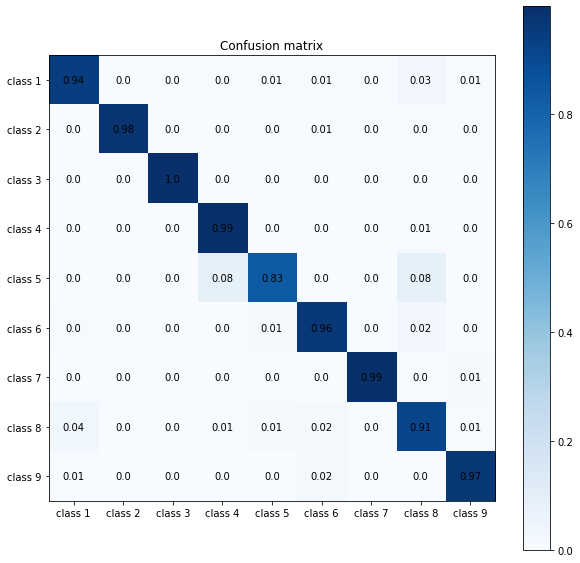

In [31]:
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=seed)
rf = LogisticRegression(max_iter=1000, class_weight='balanced')
rf.fit(X_train, y_train)
model_test(rf,X_test,y_test)

Logloss:0.05894729113819962
Accuracy:0.985280588776449


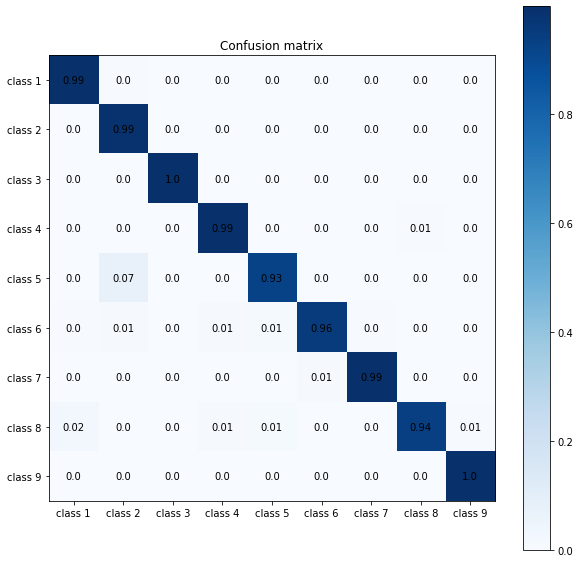

In [36]:
# stacking
def get_stacking():
    # level0 je base models
    level0 = list()
    level0.append(('lg', LogisticRegression(max_iter=1000, class_weight='balanced')))
    level0.append(('xgb', xgb.XGBClassifier(**xgb_params)))
    level0.append(('kn', ExtraTreesClassifier(**rf_params)))
    # level1 je learner model
    level1 = LogisticRegression(max_iter=1000, class_weight='balanced')
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=47)
y_train = [int(x-1) for x in y_train]
y_test = [int(x-1) for x in y_test]

model=get_stacking()
model.fit(X_train, y_train)

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)
score_log = log_loss(y_test,pred_proba,eps=1e-15)
score_acc = accuracy_score(y_test, pred)

print('Logloss:' + str(score_log))
print('Accuracy:' + str(score_acc))
make_and_plot_confusion_matrix(y_test,pred)

Logloss:0.07086255225419609
Accuracy:0.9840539711744863


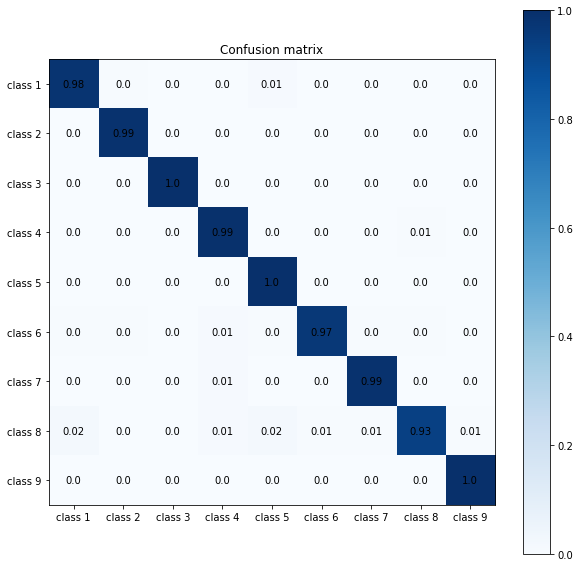

In [44]:
# stacking
def get_stacking():
    # level0 je base models
    level0 = list()
    level0.append(('xgb', xgb.XGBClassifier(**xgb_params)))
    level0.append(('kn', LogisticRegression(max_iter=1000, class_weight='balanced')))
    # level1 je learner model
    level1 = LogisticRegression(max_iter=1000, class_weight='balanced')
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=47)
y_train = [int(x-1) for x in y_train]
y_test = [int(x-1) for x in y_test]

model=get_stacking()
model.fit(X_train, y_train)

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)
score_log = log_loss(y_test,pred_proba,eps=1e-15)
score_acc = accuracy_score(y_test, pred)

print('Logloss:' + str(score_log))
print('Accuracy:' + str(score_acc))
make_and_plot_confusion_matrix(y_test,pred)

Logloss:0.0571274868670268
Accuracy:0.985280588776449


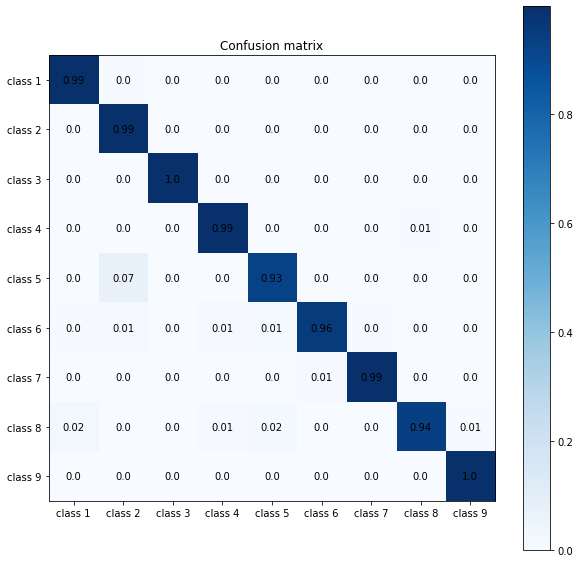

In [48]:
# stacking
def get_stacking():
    # level0 je base models
    level0 = list()
    level0.append(('xgb', XGBClassifier(**xgb_params)))
    level0.append(('kn', ExtraTreesClassifier(**rf_params)))
    level0.append(('lg', LogisticRegression(max_iter=1000, class_weight='balanced')))
    level0.append(('rf', RandomForestClassifier(**rf_params)))
    # level1 je learner model
    level1 = LogisticRegression(max_iter=1000, class_weight='balanced')
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=47)
y_train = [int(x-1) for x in y_train]
y_test = [int(x-1) for x in y_test]

model=get_stacking()
model.fit(X_train, y_train)

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)
score_log = log_loss(y_test,pred_proba,eps=1e-15)
score_acc = accuracy_score(y_test, pred)

print('Logloss:' + str(score_log))
print('Accuracy:' + str(score_acc))
make_and_plot_confusion_matrix(y_test,pred)